Temperature Analysis and Machine Learning Prediction
By Judah Kerr

In [1]:
# %load main.py
"""
Created on Mon Jan 22 12:47:29 2024

@author: Judah
"""
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns
import ipywidgets as widgets
from IPython.display import display
from sklearn import linear_model
pd.options.mode.copy_on_write = True 

import warnings

# Suppress specific sklearn warning
warnings.filterwarnings(action='ignore', category=UserWarning, module='sklearn')

# Initialize the linear regression model at the top level
reg = linear_model.LinearRegression()


def load_data(filepath):
    """Load and return the temperature dataset."""
    return pd.read_csv(filepath)

def clean_data(df, temp_column='AverageTemperature'):
    """Clean the dataset by removing rows with missing values in the specified temperature column."""
    return df.dropna(subset=[temp_column])


def filter_city_data(df, city_name, start_year=1800):
    """Filter data for a specific city and starting from a given year."""
    city_data = df[df['City'] == city_name].copy()
    city_data['dt'] = pd.to_datetime(city_data['dt'])
    city_data['year'] = city_data['dt'].dt.year
    return city_data[city_data['year'] >= start_year]

def filter_country_data(df, country_name, start_year=1825):
    """Filter data for a specific country and starting from a given year."""
    country_data = df[df['Country'] == country_name].copy()
    country_data['dt'] = pd.to_datetime(country_data['dt'])
    country_data['year'] = country_data['dt'].dt.year
    return country_data[country_data['year'] >= start_year]

def convert_celsius_to_fahrenheit(df, temp_column):
    """Convert temperatures from Celsius to Fahrenheit in the specified column."""
    df[temp_column] = df[temp_column].apply(lambda x: (x * 9/5) + 32)
    return df  



def calculate_yearly_averages(df, temp_column='AverageTemperature'):
    """Calculate yearly average temperatures for a specified column."""
    yearly_avg_temp = df.groupby('year')[temp_column].mean().reset_index()
    Q1 = yearly_avg_temp[temp_column].quantile(0.25)
    Q3 = yearly_avg_temp[temp_column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return yearly_avg_temp[(yearly_avg_temp[temp_column] >= lower_bound) & (yearly_avg_temp[temp_column] <= upper_bound)]


def add_moving_average(df, temp_column='AverageTemperature', window_size=12):
    """Add a moving average column to the DataFrame."""
    df['MovingAverage'] = df[temp_column].rolling(window=window_size).mean()
    return df


def plot_temperature_trends(df, title, future_years=None, future_temps=None, temp_column='AverageTemperature'):
    """Plot the temperature trends, moving average, and predictions."""
    plt.figure(figsize=(10, 6))
    plt.plot(df['year'], df[temp_column], linestyle='-', label='Yearly Avg Temp F°')
    plt.plot(df['year'], df['MovingAverage'], linestyle='-', color='red', label='Moving Avg')
    
    # Plot predictions if future data is provided
    if future_years is not None and future_temps is not None:
        plt.plot(future_years.flatten(), future_temps, linestyle='--', color='green', label='Predicted Temp')
    
    plt.title(title)
    plt.xlabel('Year')
    plt.ylabel('Average Temperature F°')
    plt.legend()
    plt.show()

# Function to update plot based on the selected year range
def update_plot(year_range):
    start_year, end_year = year_range
    extended_years_df = pd.DataFrame(np.arange(start_year, end_year + 1), columns=['year'])
    extended_temps = reg.predict(extended_years_df)
    plt.figure(figsize=(10, 6))
    
    plt.plot(existing_years, existing_temps, label='Actual Data')
    plt.plot(extended_years_df['year'], extended_temps, linestyle='--', label='Predicted Data')
    plt.title('Temperature Predictions')
    plt.xlabel('Year')
    plt.ylabel('Temperature F°')
    plt.legend()
    plt.show()

C:\Users\Judah\AppData\Local\Temp\ipykernel_26884\2546352618.py:7: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
def US(selected_year):
    global reg
    # Load and clean the data
    filepath = "csv/GlobalLandTemperaturesByCountry.csv"
    df = load_data(filepath)
    df_cleaned = clean_data(df, 'AverageTemperature')
    df_converted = convert_celsius_to_fahrenheit(df_cleaned, 'AverageTemperature')

    # Filter data up to the selected year
    US_data = filter_country_data(df_converted, 'United States', start_year=1850)

    # Calculate yearly averages and add a moving average
    US_yearly_avg = calculate_yearly_averages(US_data, 'AverageTemperature')
    US_yearly_avg_with_moving_avg = add_moving_average(US_yearly_avg, 'AverageTemperature', 12)

    # Fit the regression model on the filtered data
    reg.fit(US_yearly_avg_with_moving_avg[['year']], US_yearly_avg_with_moving_avg['AverageTemperature'])

    # Predict using the model
    extended_years = np.arange(1850, selected_year + 1).reshape(-1, 1)
    extended_temps = reg.predict(extended_years)

    # Plot the results
    plot_temperature_trends(US_yearly_avg_with_moving_avg, 'Yearly Average Temperature in the United States', extended_years, extended_temps, 'AverageTemperature')

# Create a slider for selecting the endpoint year for the US data
us_year_slider = widgets.IntSlider(value=2025, min=1855, max=2200, step=5, description='Select End Year:')
display(widgets.interactive(US, selected_year=us_year_slider))


interactive(children=(IntSlider(value=2025, description='Select End Year:', max=2200, min=1855, step=5), Outpu…

Here we have the Average Temperature of the United States as a whole.
The data starts from the year 1850 and ends in 2013.
You can drag the slider to see what the Linear Regression model predicts the temperature will be at any year up to 2200.

In [3]:
 def Global(selected_year):
    global reg
    filepath = "csv/GlobalTemperatures.csv"
    df = load_data(filepath)
    
    # Clean data
    df_cleaned = clean_data(df, 'LandAverageTemperature')
    
    # Convert temperatures from Celsius to Fahrenheit
    df_converted = convert_celsius_to_fahrenheit(df_cleaned, 'LandAverageTemperature')
    
    # Convert 'dt' to datetime and extract the year
    df_cleaned['dt'] = pd.to_datetime(df_cleaned['dt'])
    df_cleaned['year'] = df_cleaned['dt'].dt.year
    
    # Filter data from 1825 onwards
    Global_data = df_cleaned[df_cleaned['year'] >= 1850]
    
    # Calculate yearly averages and add moving average
    Global_yearly_avg = calculate_yearly_averages(Global_data, 'LandAverageTemperature')
    Global_yearly_avg_with_moving_avg = add_moving_average(Global_yearly_avg, 'LandAverageTemperature', 12)
 
    # Train the linear regression model
    reg.fit(Global_yearly_avg_with_moving_avg[['year']], Global_yearly_avg_with_moving_avg['LandAverageTemperature'])
    
     # Predict using the model
    extended_years = np.arange(1850, selected_year + 1).reshape(-1, 1) 
    extended_temps = reg.predict(extended_years)

    # Plot the results
    plot_temperature_trends(Global_yearly_avg_with_moving_avg, 'Yearly Average Temperature on Earth', extended_years, extended_temps, 'LandAverageTemperature')

# Create a slider for selecting the endpoint year for Global
global_year_slider = widgets.IntSlider(value=2025, min=1855, max=2200, step=5, description='Select End Year:')
display(widgets.interactive(Global, selected_year=us_year_slider))   


interactive(children=(IntSlider(value=2025, description='Select End Year:', max=2200, min=1855, step=5), Outpu…

This is the Average Land Temperature of the Earth.
The data starts from the year 1850 and ends in 2013.

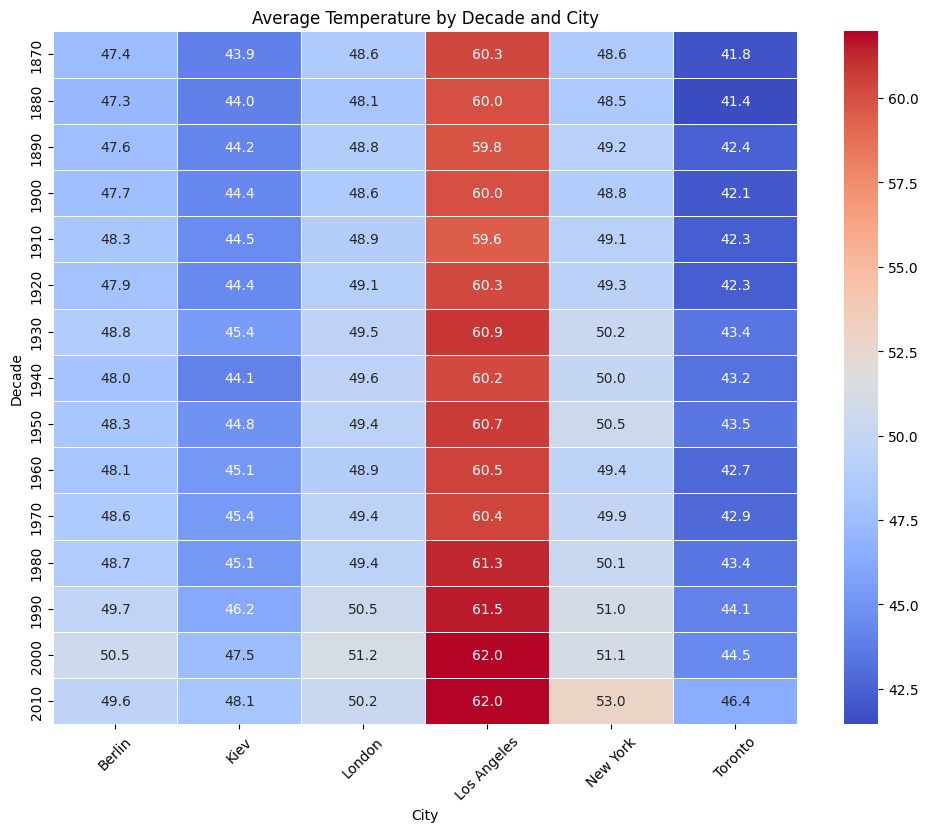

In [4]:
# Load, clean, and convert temperature data
filepath = "csv/GlobalLandTemperaturesByMajorCity.csv"
df = load_data(filepath)
df_cleaned = clean_data(df, 'AverageTemperature')
df_converted = convert_celsius_to_fahrenheit(df_cleaned, 'AverageTemperature')

# Extract the year from the 'dt' column and create a 'decade' column
df_converted['year'] = pd.to_datetime(df_converted['dt']).dt.year
df_converted = df_converted[df_converted['year'] >= 1870]
df_converted['decade'] = (df_converted['year'] // 10) * 10  # Integer division to get the decade

# Filter for cities of interest
cities_of_interest = ['Berlin', 'Toronto', 'Kiev', 'London', 'New York', 'Los Angeles']
df_filtered = df_converted[df_converted['City'].isin(cities_of_interest)]

# Group by decade and city, then calculate the average temperature
df_grouped = df_filtered.groupby(['decade', 'City'])['AverageTemperature'].mean().reset_index()

# Pivot the grouped DataFrame for heatmap data
heatmap_data = df_grouped.pivot(index="decade", columns="City", values="AverageTemperature")

# Create the heatmap
plt.figure(figsize=(12, 9))
sns.heatmap(heatmap_data, annot=True, fmt=".1f", cmap='coolwarm', linewidths=.5)

plt.title('Average Temperature by Decade and City')
plt.ylabel('Decade')
plt.xlabel('City')
plt.xticks(rotation=45) 
plt.show()

In [5]:
def GlobalLandAndOcean():
    global reg
    filepath = "csv/GlobalTemperatures.csv"
    df = load_data(filepath)
    
    # Clean data for 'LandAndOceanAverageTemperature'
    df_cleaned = df.dropna(subset=['LandAndOceanAverageTemperature']).copy()
    
    # Convert temperatures from Celsius to Fahrenheit for 'LandAndOceanAverageTemperature'
    df_cleaned = convert_celsius_to_fahrenheit(df_cleaned, 'LandAndOceanAverageTemperature')
    
    # Convert 'dt' to datetime and extract the year
    df_cleaned['dt'] = pd.to_datetime(df_cleaned['dt'])
    df_cleaned['year'] = df_cleaned['dt'].dt.year
    
    # Filter data from 1825 onwards
    GlobalLandAndOcean_data = df_cleaned[df_cleaned['year'] >= 1825]
    
    # Calculate yearly averages and add moving average for 'LandAndOceanAverageTemperature'
    GlobalLandAndOcean_yearly_avg = calculate_yearly_averages(GlobalLandAndOcean_data, 'LandAndOceanAverageTemperature')
    GlobalLandAndOcean_yearly_avg_with_moving_avg = add_moving_average(GlobalLandAndOcean_yearly_avg, 'LandAndOceanAverageTemperature', 12)
    
    # Define start_year and end_year based on your data or specific needs
    start_year = GlobalLandAndOcean_data['year'].min() 
    end_year = GlobalLandAndOcean_data['year'].max()  
    
    # Train the linear regression model
    reg.fit(GlobalLandAndOcean_yearly_avg_with_moving_avg[['year']], GlobalLandAndOcean_yearly_avg_with_moving_avg['LandAndOceanAverageTemperature'])
    
    # Create the numpy array for prediction
    extended_years_np = np.arange(start_year, end_year + 1).reshape(-1, 1)
    extended_temps = reg.predict(extended_years_np)
   
    # Plotting
    plot_temperature_trends(GlobalLandAndOcean_yearly_avg_with_moving_avg, 'Yearly Average Temperature Globally (Land and Ocean, Filtered, from 1825)', extended_years_np, extended_temps, 'LandAndOceanAverageTemperature')
    




# Main analysis for New York
def NY():
    global reg
    filepath = "csv/GlobalLandTemperaturesByMajorCity.csv"
    df = load_data(filepath)
    
    
    df_cleaned = clean_data(df, 'AverageTemperature') 
    
    df_converted = convert_celsius_to_fahrenheit(df_cleaned, 'AverageTemperature')
    
    newYork_data = filter_city_data(df_converted, 'New York', 1800)
    
    newYork_yearly_avg = calculate_yearly_averages(newYork_data, 'AverageTemperature')
    newYork_yearly_avg_with_moving_avg = add_moving_average(newYork_yearly_avg, 'AverageTemperature', 12)
    
    reg = linear_model.LinearRegression()
    X = newYork_yearly_avg_with_moving_avg[['year']]
    y = newYork_yearly_avg_with_moving_avg['AverageTemperature']
    reg.fit(X, y)
    
    start_year = X['year'].iloc[0]
    end_year = X['year'].iloc[-1] + 100
    extended_years = np.arange(start_year, end_year + 1).reshape(-1, 1)
    
    extended_temps = reg.predict(extended_years)
    
    plot_temperature_trends(newYork_yearly_avg_with_moving_avg, 'Yearly Average Temperature in New York (Filtered, from 1800)', extended_years, extended_temps, 'AverageTemperature')

    
# Main analysis for Los Angeles
def LA():
    global reg
    # Load and clean the data
    filepath = "csv/GlobalLandTemperaturesByMajorCity.csv"
    df = load_data(filepath)
    df_cleaned = clean_data(df, 'AverageTemperature')
    df_converted = convert_celsius_to_fahrenheit(df_cleaned, 'AverageTemperature')
    
    # Filter data for New York starting from 1800
    LosAngeles_data = filter_city_data(df_converted, 'Los Angeles', 1800)
    
    # Calculate yearly averages and add moving average
    LosAngeles_yearly_avg = calculate_yearly_averages(LosAngeles_data)
    LosAngeles_yearly_avg_with_moving_avg = add_moving_average(LosAngeles_yearly_avg, 'AverageTemperature', 12)

    
    reg = linear_model.LinearRegression()
    X = LosAngeles_yearly_avg_with_moving_avg[['year']]
    y = LosAngeles_yearly_avg_with_moving_avg['AverageTemperature']
    reg.fit(X, y)
    
    start_year = X['year'].iloc[0]
    end_year = X['year'].iloc[-1] + 100
    extended_years = np.arange(start_year, end_year + 1).reshape(-1, 1)
    
    extended_temps = reg.predict(extended_years)
    
    plot_temperature_trends(LosAngeles_yearly_avg_with_moving_avg, 'Yearly Average Temperature in LosAngeles (Filtered, from 1800)', extended_years, extended_temps, 'AverageTemperature')
    

#if __name__ == '__main__':

    #GlobalLandAndOcean()
    #NY()
    #LA()





